<a href="https://colab.research.google.com/github/GonzaloPerezGomez/Pytorch/blob/main/03_Computer_Vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch Computer Vision

## 0. Computer vision libaries

* torchvision - base domain library for PyTorch computer vision
* torchvision.datasets - Datasets and DataLoading funtions for cumputer vision
* torchvision.models - get pretrained computer vision models
* torchvision.transforms - functions for manipulating your vision data to be suitable for use with ML model
+ torch.utils.data.Dataset - Base dataset class ofr Pytorch
* torch.util.data.DataLoader - Creates a Python iterable over a dataset

In [ ]:
# Import PyTorch
import torch
from torch import nn

# Improt torchvision
import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor

# Import matplotlib for visualization
import matplotlib.pyplot as plt

## 1. Getting a Dataset

FashionMNIST

In [ ]:
# Setup training data
train_data = datasets.FashionMNIST(root="data", # Whare to download data to
                                   train=True,
                                   download=True,
                                   transform=ToTensor(),
                                   target_transform=None
                                  )

test_data = datasets.FashionMNIST(root="data", # Whare to download data to
                                   train=False,
                                   download=True,
                                   transform=ToTensor(),
                                   target_transform=None
                                  )

100%|██████████| 26.4M/26.4M [00:02<00:00, 10.5MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 200kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.74MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 12.1MB/s]


In [ ]:
len(train_data), len(test_data)

(60000, 10000)

In [ ]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [ ]:
 # Color_Channel (black and white), Height, Width
train_data[0][0].shape, train_data[0][1]

(torch.Size([1, 28, 28]), 9)

### 1.3 Visualizing out data

torch.Size([28, 28])

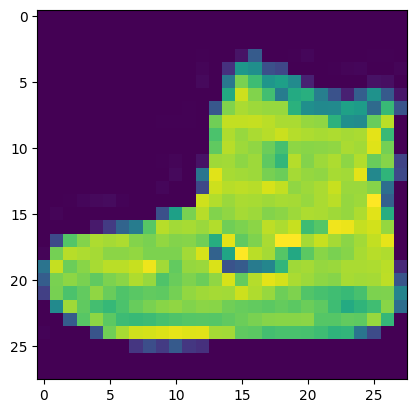

In [ ]:
image, label = train_data[0]
plt.imshow(image.transpose(0, 2).transpose(0, 1)) # plt.imshow expects (Height, Width, Color_Cannel)
#plt.imshow(image.squeeze()) becuase the image is in black and white (Color_Channel = 1) we can algo get reed of the extra dimension
image.squeeze().shape

(np.float64(-0.5), np.float64(27.5), np.float64(27.5), np.float64(-0.5))

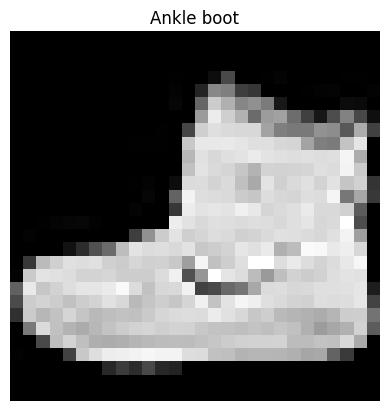

In [ ]:
plt.imshow(image.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis(False)

## 2. Prepare DataLoader

Our data is in the form of PyTorch Datasets. We want to turn it into Python iterable

Also we want to devide it in batches, so we can handle de data in "blocks"

In [ ]:
from torch.utils.data import DataLoader

# Setup the batch size hyperparameter
BATCH_SIZE = 32

# Turn datasets into iterables
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False)

In [ ]:
# Lets check out what we`ve created
print(f"Legth of train_dataloader: {len(train_dataloader)} batches of {train_dataloader.batch_size}")
print(f"Legth of train_dataloader: {len(test_dataloader)} batches of {test_dataloader.batch_size}")


Legth of train_dataloader: 1875 batches of 32
Legth of train_dataloader: 313 batches of 32


In [ ]:
# Whats inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

(np.float64(-0.5), np.float64(27.5), np.float64(27.5), np.float64(-0.5))

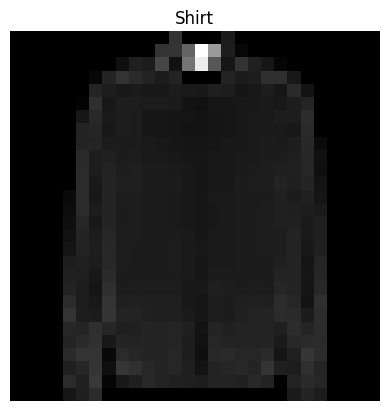

In [ ]:
# Show a sample
torch.manual_seed(42)
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis(False)

## 3. Model 0: Build a baseline model

In [ ]:
#Create a flatten layer
flatten_model = nn.Flatten()

#Get a single sample
x = train_features_batch[0]
x.shape

torch.Size([1, 28, 28])

In [ ]:
# Flatten de sample
output = flatten_model(x)
output.shape

torch.Size([1, 784])

In [ ]:
class FashionMNISTModelV0(nn.Module):
  def __init__(self,
               input_shape: int,
               hidden_unit: int,
               output_shape: int):
    super().__init__()

    self.layer_stack = nn.Sequential(
        nn.Flatten(),

        nn.Linear(in_features=input_shape,
                  out_features=hidden_unit),

        nn.Linear(in_features=hidden_unit,
                  out_features=output_shape)
    )

  def forward(self,x):
    return self.layer_stack(x)

In [ ]:
torch.manual_seed(42)

model_0 = FashionMNISTModelV0(
    input_shape=784, # 28*28
    hidden_unit=10,
    output_shape=len(class_names)
).to("cpu")

model_0

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [ ]:
dummy_x = torch.rand([1, 1, 28, 28])
model_0(dummy_x)

tensor([[-0.0315,  0.3171,  0.0531, -0.2525,  0.5959,  0.2112,  0.3233,  0.2694,
         -0.1004,  0.0157]], grad_fn=<AddmmBackward0>)

### 3.1 Setup loss, optimizer and evaluation metrics

* Loss function - multi-class data so nn.CrossEntropyLoss()
* Optimizer - toch.optim.SGD
* Evaluation - classification problem, so accuracy

In [ ]:
import requests
from pathlib import Path

# Download helper funtion from Lean PyTorch
if not Path("help_functions.py").is_file():
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py")
  with open("help_functions.py", "wb") as f:
    f.write(request.content)

from help_functions import plot_predictions, plot_decision_boundary, accuracy_fn

In [ ]:
# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr = 0.1)

### 3.2 Creating a function to time our experiments

In [ ]:
from timeit import default_timer as timer
def print_train_time(start: float,
                     end: float,
                     device: torch.device=None):
  total_time= end-start
  print(f"Train time on {device}: {total_time:.3f} seconds")
  return total_time

In [ ]:
start_time = timer()

end_time = timer()
print_train_time(start_time, end_time)

Train time on None: 0.000 seconds


4.359499999395666e-05

### 3.3 Train loop in batches of data

1. Loop through epochs
2. Loop through batchs, perform training steps, calculate the train loss *per batch*
3. Loop through batchs, perform testing steps, calculate the test loss *per batch*
4. Print what´s happening
5. Time it all

In [ ]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# Set the seed
torch.manual_seed(42)
train_time_start_on_cpu = timer()

epochs = 3

# Create the train loop
for epoch in tqdm(range(epochs)):
  ### Train
  train_loss = 0

  print(f"Epoch: {epoch} \n-------------------")
  # Add a loop to loop through the training batches
  for batch, (X, y) in enumerate(train_dataloader):

    model_0.train()
    # Forward pass
    y_pred = model_0(X)

    # Calculate the loss
    loss = loss_fn(y_pred, y)
    train_loss += loss

    # Optimizer zero grad
    optimizer.zero_grad()

    # Loos backward
    loss.backward()

    # Optimizer step
    optimizer.step()

    # Print out
    if batch % 400 == 0:
      print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")

  # Divide total train loss by length of train dataloades
  train_loss /= len(train_dataloader)

  ### Testing
  test_loss, test_acc = 0, 0
  model_0.eval()
  with torch.inference_mode():
    for X_test, y_test in test_dataloader:

      test_pred = model_0(X_test)

      test_loss += loss_fn(test_pred, y_test)

      test_acc += accuracy_fn(y_test, test_pred.argmax(dim=1))

    test_loss /= len(test_dataloader)

    test_acc /= len(test_dataloader)

  # Print out
  print(f"\nTrain Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f} | Test Acc {test_acc:.2f}%")

# Calculate training time
train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(train_time_start_on_cpu,
                                            train_time_end_on_cpu,
                                            str(next(model_0.parameters()).device))






  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0 
-------------------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train Loss: 0.5904 | Test Loss: 0.5095 | Test Acc 82.04%
Epoch: 1 
-------------------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train Loss: 0.4763 | Test Loss: 0.4799 | Test Acc 83.20%
Epoch: 2 
-------------------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train Loss: 0.4550 | Test Loss: 0.4766 | Test Acc 83.43%
Train time on cpu: 24.053 seconds


## 4. Make prediction and get Model 0 results

In [ ]:
torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn):

  loss, acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for X, y in data_loader:

      y_pred = model(X)

      loss += loss_fn(y_pred, y)

      acc += accuracy_fn(y, y_pred.argmax(dim=1))

    loss /= len(data_loader)
    acc /= len(data_loader)

  return {f"model_name": model.__call__.__name__,
          f"model_loss": loss.item(),
          f"model_acc": acc}

# Calculate model = results on test dataset
model_0_results = eval_model(model_0, test_dataloader, loss_fn, accuracy_fn)
model_0_results



{'model_name': '_wrapped_call_impl',
 'model_loss': 0.47663888335227966,
 'model_acc': 83.42651757188499}

## 5. Setup device agnostic code

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'